In [1]:
from Chemometrics.basic import pload,plot_ConfusionMatrix,build_clf,cal_pct
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,GroupShuffleSplit,StratifiedShuffleSplit
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.style.use('ggplot')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\matplotlibrc


- prepare the data

In [77]:
# representative sample, group statified split
data = pload('./地沟油红外数据及标签.p')
ir = data['IR']
desc = data['descriptions']
labels = desc['地沟油含量']
label_ = ~labels.isnull()
rseed = 1
cond1 = ((~desc['品牌'].isnull()) & (desc['备注'].isnull()))
cond2 = np.isclose(desc['地沟油含量'],1)
cond3 = (desc['地沟油含量'].isnull() & desc['品牌'].isnull())
representatives = (cond1 | cond2 )| cond3
ir_n = ir[~representatives] # not representative
label_n = label_[~representatives] # not representative
ir = ir[representatives]
label = label_[representatives]
desc = desc[~desc.index.duplicated(keep='first')]
# train test split
# stratified group split
train,test= train_test_split(label.index.unique(),test_size=.25,random_state=2)
X_train,X_test = ir[ir.index.isin(train)],ir[ir.index.isin(test)]
y_train,y_test = label[label.index.isin(train)],label[label.index.isin(test)]

In [3]:
a = pd.concat([X_train,X_test,ir_n])
b = pd.concat([y_train,y_test,label_n])

In [4]:
e = pd.Series(index=a.index,name='分组')
e[e.index.isin(X_train.index)] = '训练集'
e[e.index.isin(X_test.index)] = '测试集1'
e[e.index.isin(label_n.index)] = '测试集2'
e = e+b.map(str)

In [5]:
t = desc.loc[e.index].reset_index().reset_index()
n = t['index'].map(str)+t['分类']
n.index=e.index

In [6]:
xls = pd.concat([n,e,a],axis=1)

In [7]:
#xls.to_excel('地沟油_分组_chempattern.xlsx')

---


# EDA

In [8]:
x_ = data['IR']
l_ = ~data['descriptions']['地沟油含量'].isnull()
x_.shape,l_.shape

((138, 6701), (138,))

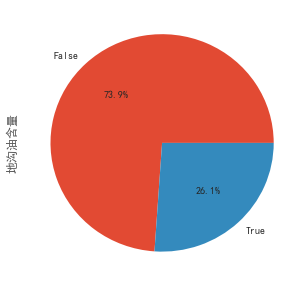

In [85]:
# prior
f_pie = plt.figure(figsize=(5,5))
l_.value_counts().plot.pie(autopct='%1.1f%%')

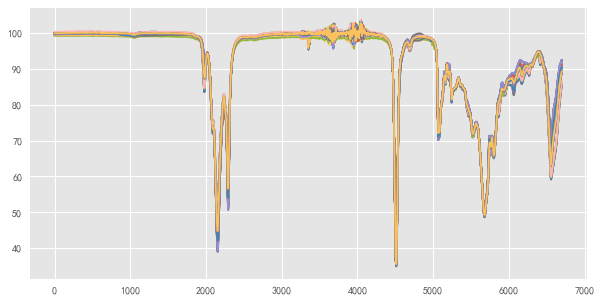

In [10]:
f_ir = plt.figure(figsize=(10,5))
lines = plt.plot(x_.T.values)

In [87]:
# 变量分分析

In [ ]:
from sklearn.feature_selection import SelectKBest,chi2

ir.T.plot(legend=False)

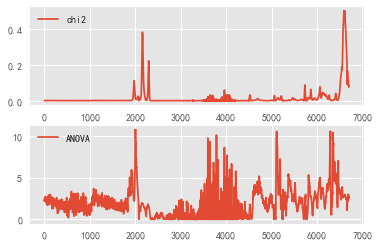

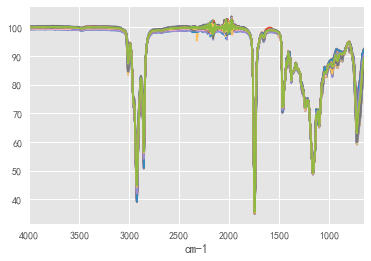

In [93]:
from sklearn.feature_selection import SelectKBest,chi2
a = SelectKBest(chi2,k='all').fit(ir,label)
plt.subplot(2,1,1)
plt.plot(a.scores_,label='chi2')
plt.legend()
b = SelectKBest(k='all').fit(ir,label)
plt.subplot(2,1,2)
plt.plot(b.scores_,label='ANOVA')
plt.legend()
ir.T.plot(legend=False)

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA(n_components=10)
score = pca.fit_transform(x_)
score.shape

(138, 10)

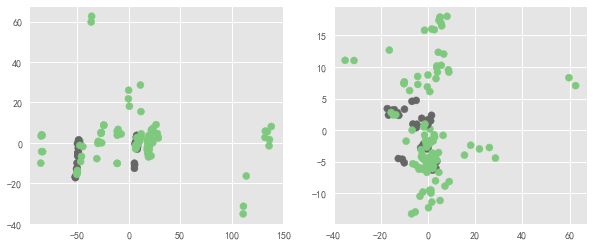

In [13]:
f_pca = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(score[:,0],score[:,1],c=l_,cmap=plt.cm.Accent)
plt.subplot(1,2,2)
a = plt.scatter(score[:,1],score[:,2],c=l_,cmap=plt.cm.Accent)

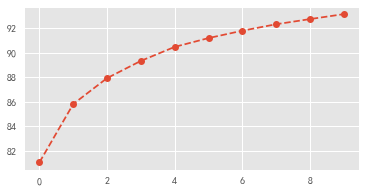

In [14]:
f_evr = plt.figure(figsize=(6,3))
plt.plot(pca.explained_variance_ratio_.cumsum()*100,'o--')

---
# 建模

In [15]:
# resample
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=rseed)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

- 支持向量机

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [18]:
params_svc = {'C':2.**np.array(range(-10,10))}

In [19]:
# svc = svc.fit(X_resampled, y_resampled) # 不进行参数优化好一点？

In [33]:
from sklearn.model_selection import LeaveOneOut,LeavePOut
# cv
cv = GroupShuffleSplit(random_state=rseed).split(X_train,y_train,y_train.index)
grid = GridSearchCV(SVC(),param_grid=params_svc,cv=cv)
grid.fit(X_resampled,y_resampled)

GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x000001EF18291FC0>,
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([9.76562e-04, 1.95312e-03, 3.90625e-03, 7.81250e-03, 1.56250e-02,
       3.12500e-02, 6.25000e-02, 1.25000e-01, 2.50000e-01, 5.00000e-01,
       1.00000e+00, 2.00000e+00, 4.00000e+00, 8.00000e+00, 1.60000e+01,
       3.20000e+01, 6.40000e+01, 1.28000e+02, 2.56000e+02, 5.12000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# 判断是否done overfitting

In [21]:
from sklearn.metrics import accuracy_score,f1_score,r2_score

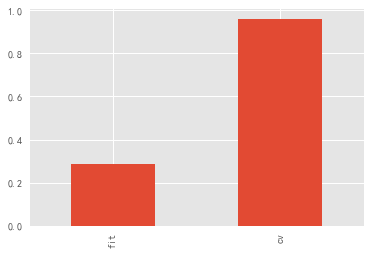

In [34]:
accs = [accuracy_score(y_train,grid.predict(X_train)),grid.best_score_]
accs = pd.Series(accs,index=['fit','cv'])
f = accs.plot.bar()

In [35]:
of = accs['fit']-accs['cv']
print('degree of overfitting is {of}%'.format(of=round(of*100,2)))

degree of overfitting is -67.21%


---
# Evaluate
- test set

测试集f1 Score为0.3


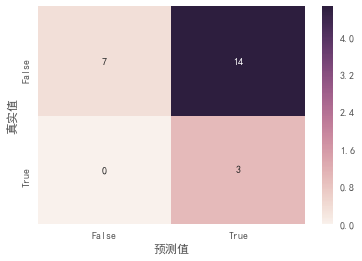

In [36]:
svc = grid
sp = svc.predict(X_test)
cm = confusion_matrix(y_test,sp,svc.classes_)
plot_ConfusionMatrix(cm,svc.classes_)
print('测试集f1 Score为{}'.format(f1_score(y_test,sp)))

In [25]:
# 训练集中的地沟油样本
desc.loc[y_train[y_train==True].index.unique()]

,品牌,分类,工艺,转基因,备注,种类,地沟油含量
编号,,,,,,,
Y-061,NaN,花生提-2,NaN,NaN,NaN,花生提,1.0
Y-202,NaN,玉米提-2,NaN,NaN,NaN,玉米提,1.0
Y-207,NaN,玉米提-1,NaN,NaN,NaN,玉米提,1.0


In [26]:
# 测试集中的地沟油样本
desc.loc[y_test[y_test==True].index.unique()]

,品牌,分类,工艺,转基因,备注,种类,地沟油含量
编号,,,,,,,
Y-116,NaN,花生提-1,NaN,NaN,NaN,花生提,1.0


- non representative set

测试集f1 Score为0.7692307692307693


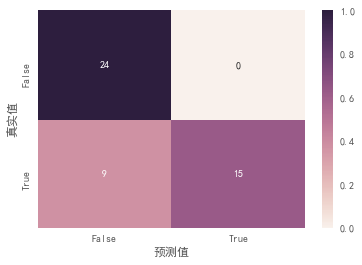

In [27]:
sp_n = svc.predict(ir_n)
cm = confusion_matrix(label_n,sp_n)
plot_ConfusionMatrix(cm,svc.classes_)
print('测试集f1 Score为{}'.format(f1_score(label_n,sp_n)))

In [53]:
desc[desc.index.isin((label_n.loc[sp_n!=label_n].index))]

,品牌,分类,工艺,转基因,备注,种类,地沟油含量
编号,,,,,,,
Y-182,NaN,花生混-60-1,NaN,NaN,NaN,花生混,0.6
Y-217,NaN,花生混-20-1,NaN,NaN,NaN,花生混,0.2
Y-236,NaN,玉米混-60-2,NaN,NaN,NaN,玉米混,0.2


# 只用花生和玉米，downsampling

In [68]:
a = desc[~desc['地沟油含量'].isnull()]['种类'].apply(lambda x:x[:-1]).unique()

In [80]:
mask = ir.index.isin(desc['种类'].map(lambda x:x[:-1]).isin(a).index)
ir = ir[mask]
label = label[mask]

In [81]:
clf = build_clf(ir,label)

In [82]:
cm=confusion_matrix(label,clf.predict(ir),clf.classes_)

0.15384615384615385

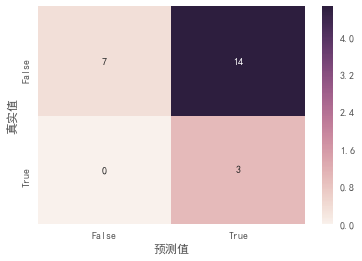

In [83]:
plot_ConfusionMatrix(cm,clf.classes_)